Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import torch
import sklearn

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36

In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }
    
class ParticleDatasetVAE():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = [x.reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE) for x in self.data['Pictures']]
        self.image = torch.stack(self.image).squeeze_().cpu().numpy()
        
    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDatasetVAE('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
0.0 1.0


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

The code snippets for this task is provided here https://github.com/msmsajjadi/precision-recall-distributions by authors of the article. <Br> The idea of algorithms is rather intuitive and well-explained in the article.

In [6]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    cluster_data = np.vstack([generated_data, real_data])
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=number_of_bins, n_init=10)
    labels = kmeans.fit(cluster_data).labels_

    generated_labels = labels[:len(generated_data)]
    real_labels = labels[len(generated_data):]

    gen_density = np.histogram(generated_labels, bins=number_of_bins,
                             range=[0, number_of_bins], density=True)[0]
    real_density = np.histogram(real_labels, bins=number_of_bins,
                          range=[0, number_of_bins], density=True)[0]
    return real_density, gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [7]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    slopes = np.tan(angles)
    slopes_2d = np.expand_dims(slopes, 1)
    real_den_2d = np.expand_dims(real_density, 0)
    gen_den_2d = np.expand_dims(gen_density, 0)
    
    alpha_vec = np.minimum(real_den_2d*slopes_2d, gen_den_2d).sum(axis=1)
    beta_vec = alpha_vec / slopes

    # handle numerical instabilities leaing to precision/recall just above 1
    max_val = max(np.max(alpha_vec), np.max(beta_vec))
    if max_val > 1.001:
        raise ValueError('Detected value > 1.001, this should not happen.')
    alpha_vec = np.clip(alpha_vec, 0, 1)
    beta_vec = np.clip(beta_vec, 0, 1)

    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [8]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

In [9]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [10]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


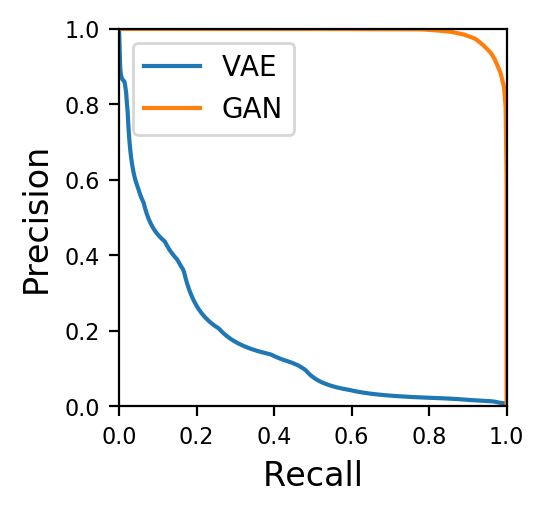

In [16]:
fig = plt.figure(figsize=(2.5,2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

$P$ - reference distribution, while $Q$ is an obtained one (i.e. generated)

**Precision** should measure how much of $Q$ can be generated by a “part” of $P$ while <br>
**recall** should measure how much of $P$ can be generated by a “part” of $Q$

If $P$ is bimodal and $Q$ only captures one of the modes, we should have perfect <Br>
precision but only limited recall.
    
So, speaking about GAN, one can observe a high recall and a high precision, which in fact says that the model generates images from all classes (modes) with acceptable level of blurriness. But this might not have been the case, GAN models are prone to mode collapse, which could have led to decreased recall. One can see what might happen in case of modes being under the target number or beyond (section 4.1 Adding and dropping modes from the target distribution)

As for VAE, the situation is very classical as this model tries to produce mode modes but images are blurrish. In fact we obtained mediocre level of precision as well as recall, which implies generation not only blurry images but also lack of modes (and prevalence of dark images).

The difference between generated images is very noticeable. So, this time GAN rules.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [ ]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
